# Connected components and morphology 2D 3D

Here we develop and evaluate the method of postprocessing of probability images produced by neural network.

There method used here is:
- connected components on global threshold
- opening

In [ ]:
from notebook_utils import *

import imageio
import skimage.segmentation
import skimage.filters

import scipy.stats

import random

import os
import shutil

%matplotlib inline

# Load input data

In [2]:
# general
dir_root = r'D:\Fafa\MIT\CellDx\watersheds'

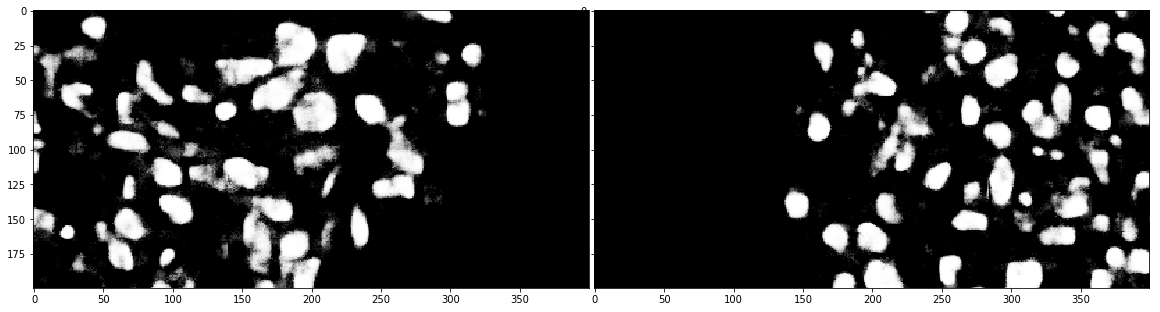

In [3]:
path_2d = os.path.join(dir_root, '017.tif')

cp_segm = imageio.imread(path_2d)
crop_1 = cp_segm[200:400,0:400] / 255.0
crop_2 = cp_segm[400:600,600:1000] / 255.0
show_all(1,2,crop_1, crop_2, scale=20)

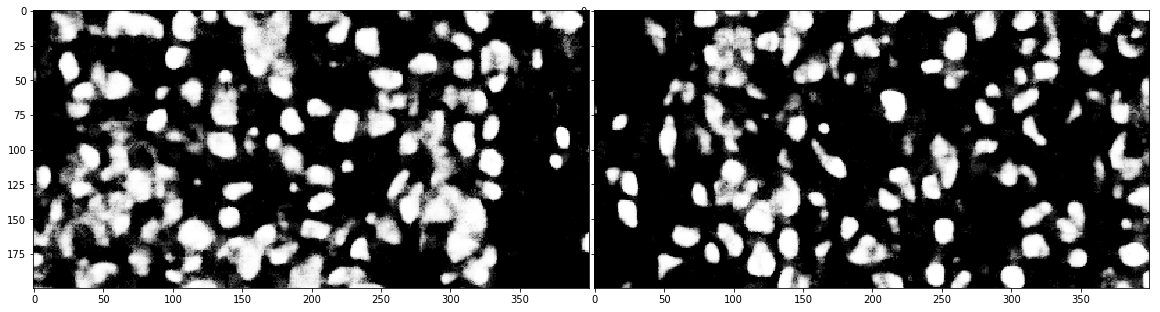

In [4]:
path_2d_2 = os.path.join(dir_root, '072.tif')

cp_segm_2 = imageio.imread(path_2d_2)
crop_b1 = cp_segm_2[200:400,0:400] / 255.0
crop_b2 = cp_segm_2[400:600,600:1000] / 255.0
show_all(1,2,crop_b1, crop_b2, scale=20)

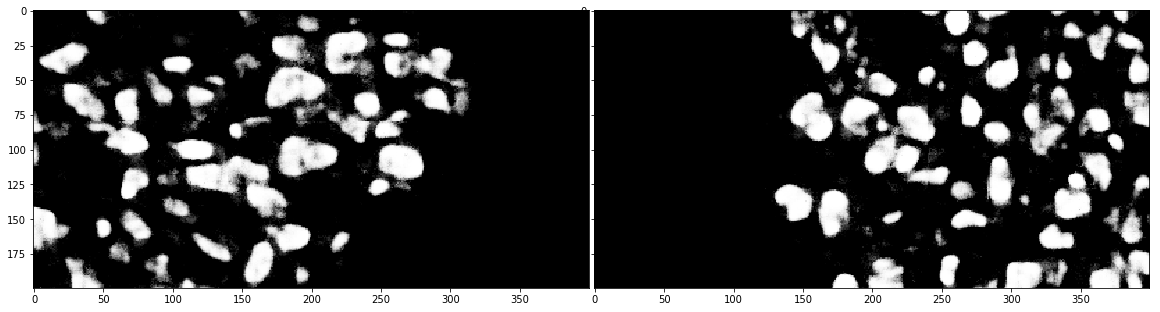

In [5]:
path_3d = os.path.join(dir_root, 'substack.tif')
cp_segm_3 = imageio.volread(path_3d) / 255.0
crop_3d_1 = cp_segm_3[::, 200:400,0:400] 
crop_3d_2 = cp_segm_3[::, 400:600,600:1000] 
show_all(1,2,crop_3d_1[0], crop_3d_2[-5], scale=20)


## Use our postprocess

In [7]:
import clb.utils
import argparse
importlib.reload(clb.utils)

Using TensorFlow backend.


<module 'cldx.utils' from 'C:\\Users\\Fafa\\dockers\\cldx-pilot\\cldx\\utils.py'>

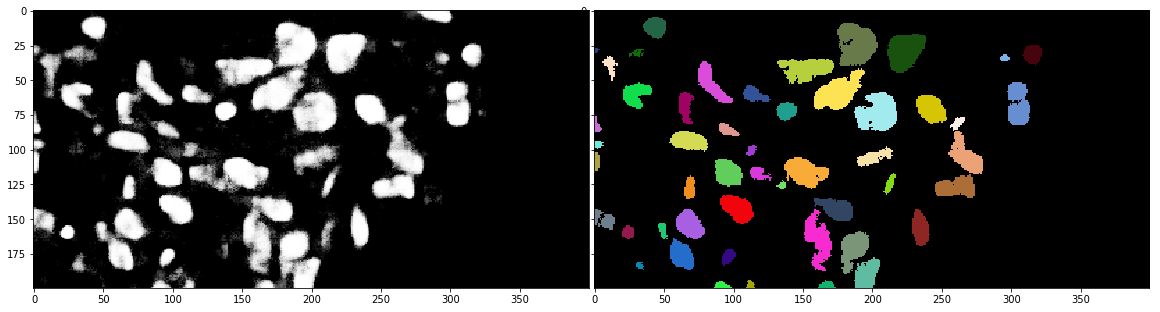

In [8]:
threshold = 0.7
im, labels = clb.utils.postprocessing(crop_1, np.array(crop_1), np.zeros(crop_1.shape), obj_threshold=threshold)
show_all(1,2,crop_1, labels, scale=20, cmap='gray,rand')

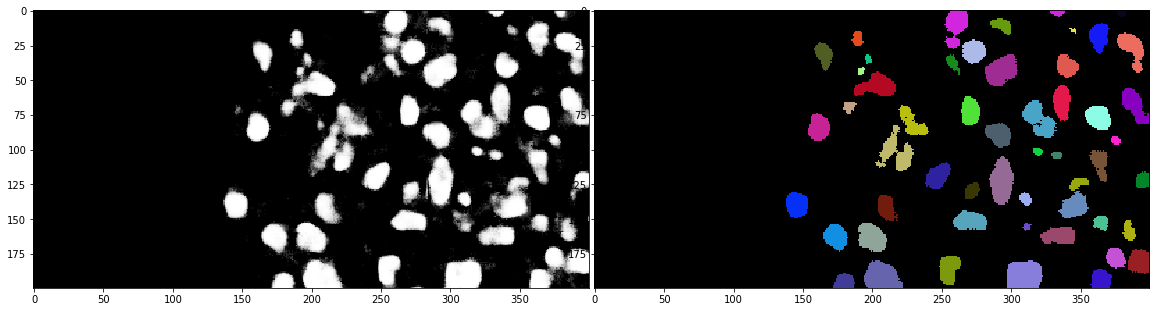

In [9]:
im, labels = clb.utils.postprocessing(crop_2, crop_2, np.zeros(crop_2.shape), obj_threshold=threshold)
show_all(1,2,crop_2, labels, scale=20, cmap='gray,rand')

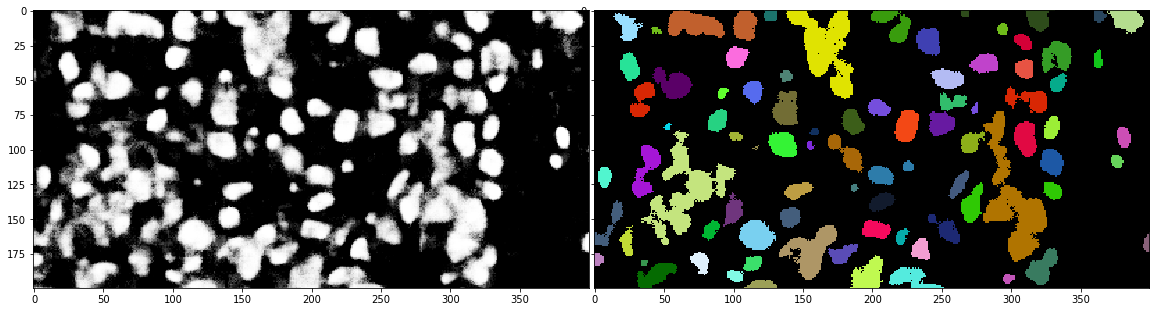

In [10]:
im, labels = clb.utils.postprocessing(crop_b1, crop_b1, np.zeros(crop_b1.shape), obj_threshold=threshold)
show_all(1,2,crop_b1, labels, scale=20, cmap='gray,rand')

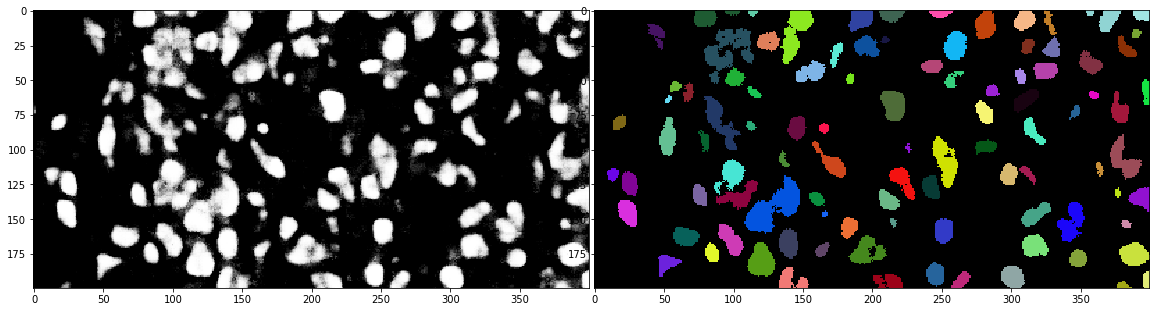

In [11]:
im, labels = clb.utils.postprocessing(crop_b2, crop_b2, np.zeros(crop_b2.shape), obj_threshold=threshold)
show_all(1,2,crop_b2, labels, scale=20, cmap='gray,rand')

### Test working in 3D

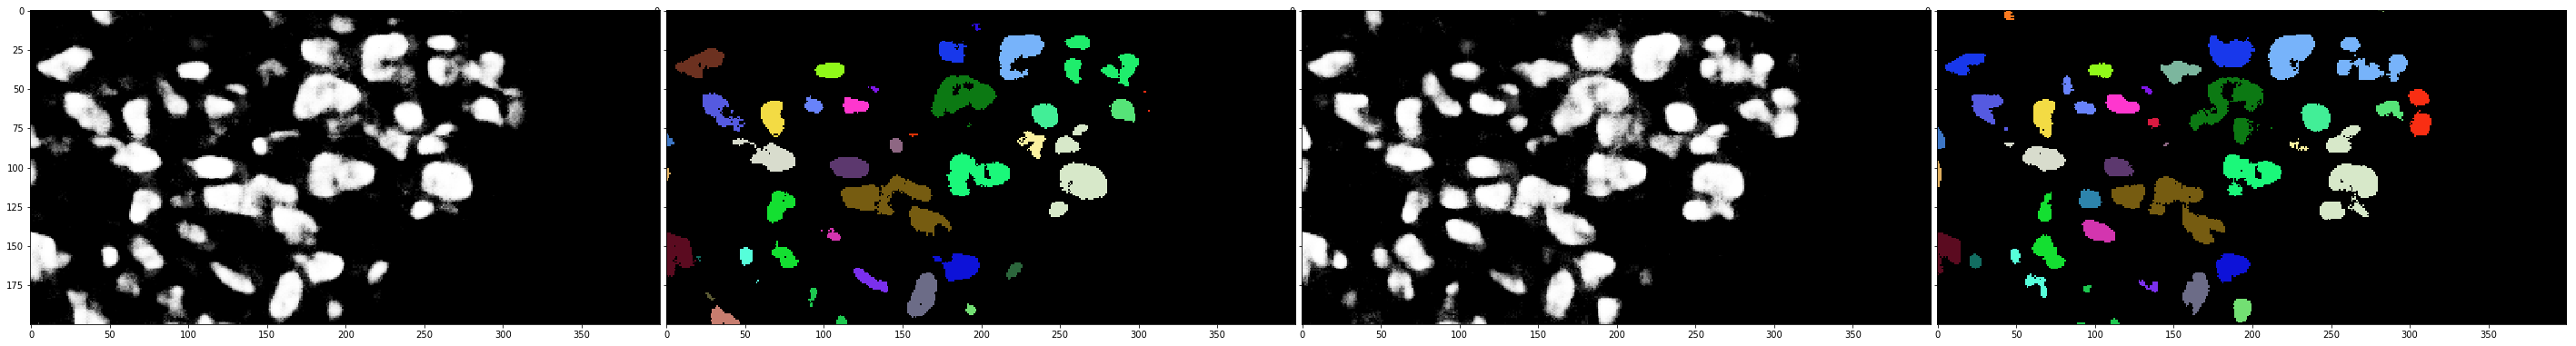

In [13]:
importlib.reload(clb.utils)

threshold = 0.87
im, labels = clb.utils.postprocessing(crop_3d_1, crop_3d_1, np.zeros(crop_3d_1.shape), obj_threshold=threshold)
show_all(1,4,crop_3d_1[0], labels[0], crop_3d_1[3], labels[3], scale=50, cmap='gray,rand')

## Identify cells with split

In [17]:
import clb.identify_cells
importlib.reload(clb.identify_cells)
importlib.reload(clb.utils)

def label_cell(v):
    return clb.identify_cells.label_cells_cc(v, 0.80, 1)

result = clb.identify_cells.label_cells_by_layers(cp_segm_3, label_cell, 5)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.17s/it]


In [18]:
import imageio
imageio.volsave("test2_ero1_80_graybin_reflect.tif", result)

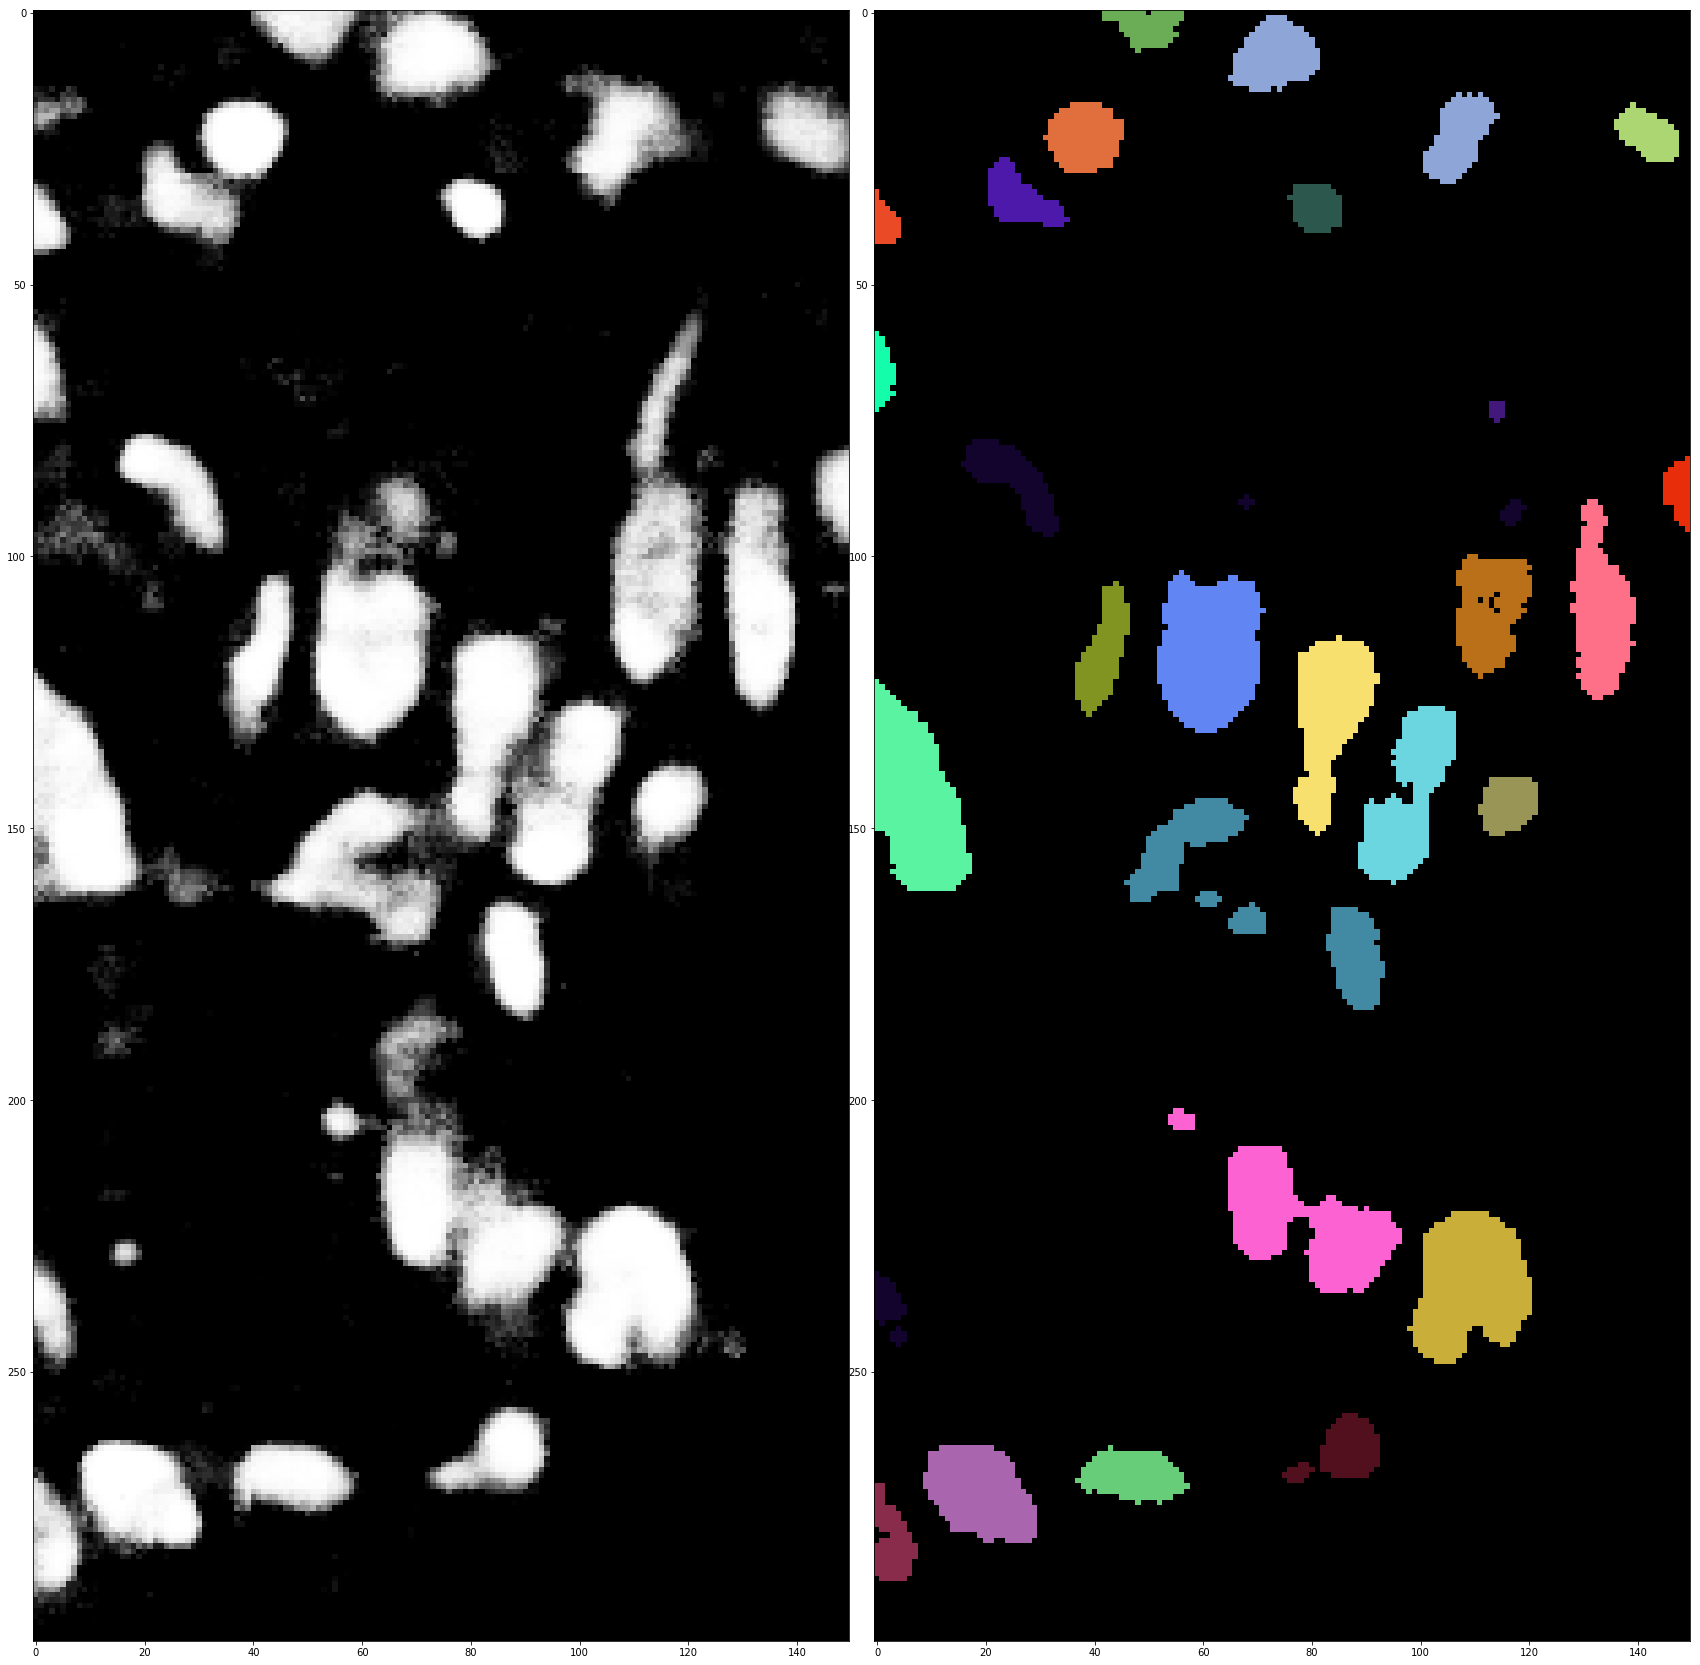

In [19]:
show_all(1,2,cp_segm_3[13][250:550,100:250],result[13][250:550,100:250], scale=30, cmap='gray,rand')

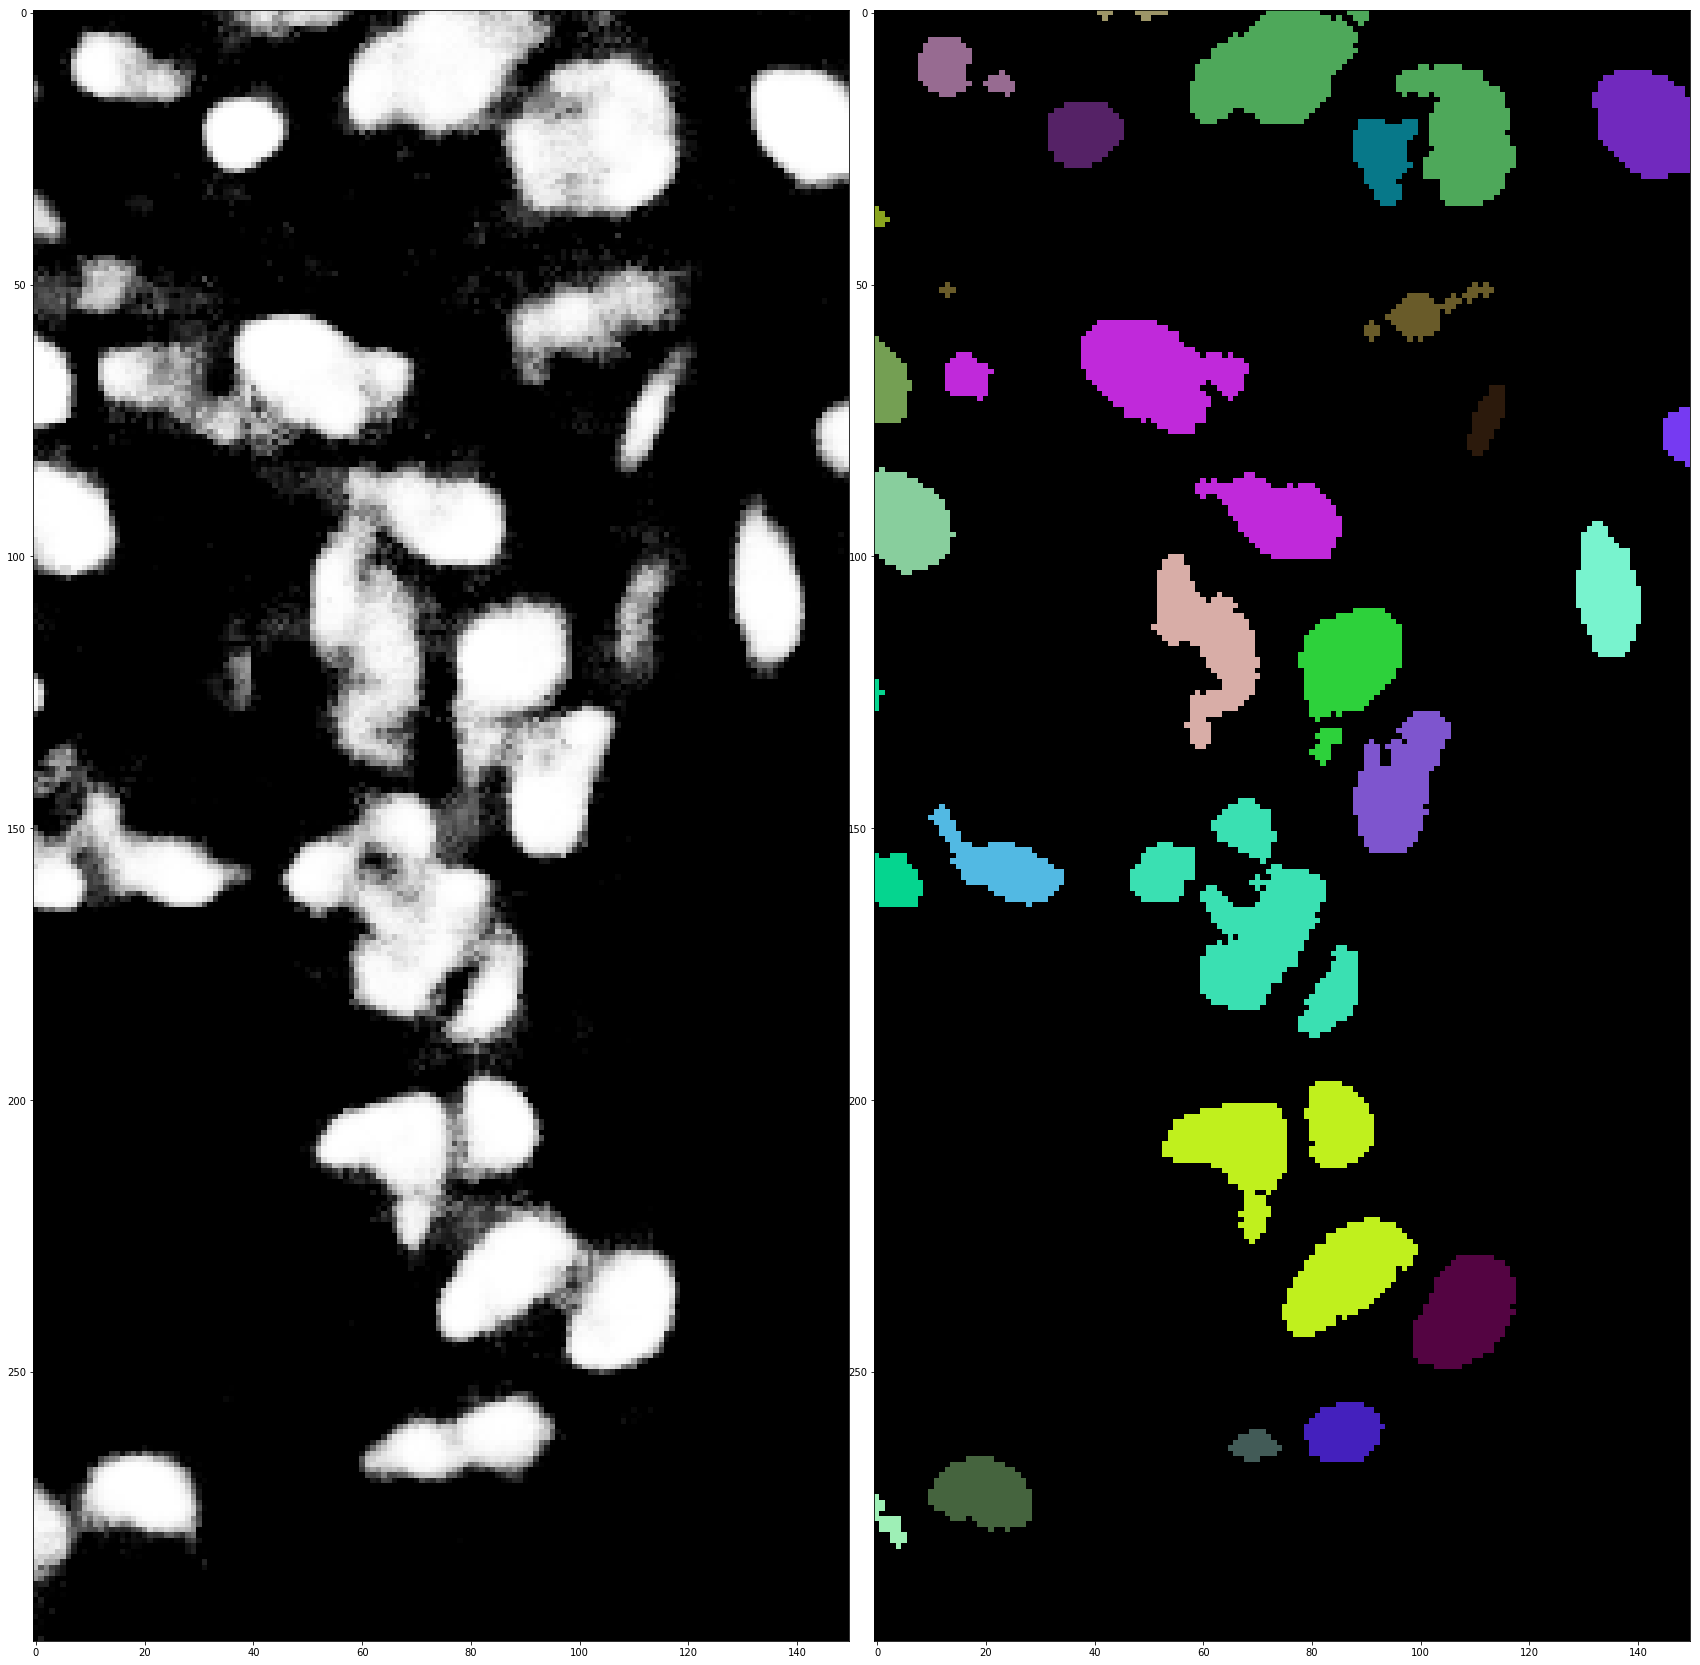

In [20]:
show_all(1,2,cp_segm_3[7][250:550,100:250],result[7][250:550,100:250], scale=30, cmap='gray,rand')

## Evaluate the use of opening

In [21]:
crop_erosion = cp_segm_3[6][250:550,100:250] > 0.80
    
struct = scipy.ndimage.morphology.generate_binary_structure(2, 1)
print(struct)
struct_it = scipy.ndimage.morphology.iterate_structure(struct, 2)
print(struct_it)
crop_erosion_opened = scipy.ndimage.morphology.binary_opening(crop_erosion, struct, iterations=2).astype(np.uint8) * 255

[[False  True False]
 [ True  True  True]
 [False  True False]]
[[False False  True False False]
 [False  True  True  True False]
 [ True  True  True  True  True]
 [False  True  True  True False]
 [False False  True False False]]


In [22]:
def create_disc(radius):
    n = radius * 2 + 1
    y,x = np.ogrid[-radius:radius+1, -radius:radius+1]
    mask = x*x + y*y <= radius*radius

    array = np.zeros((n, n),dtype=bool)
    array[mask] = True
    return array

[[False False False  True False False False]
 [False  True  True  True  True  True False]
 [False  True  True  True  True  True False]
 [ True  True  True  True  True  True  True]
 [False  True  True  True  True  True False]
 [False  True  True  True  True  True False]
 [False False False  True False False False]]


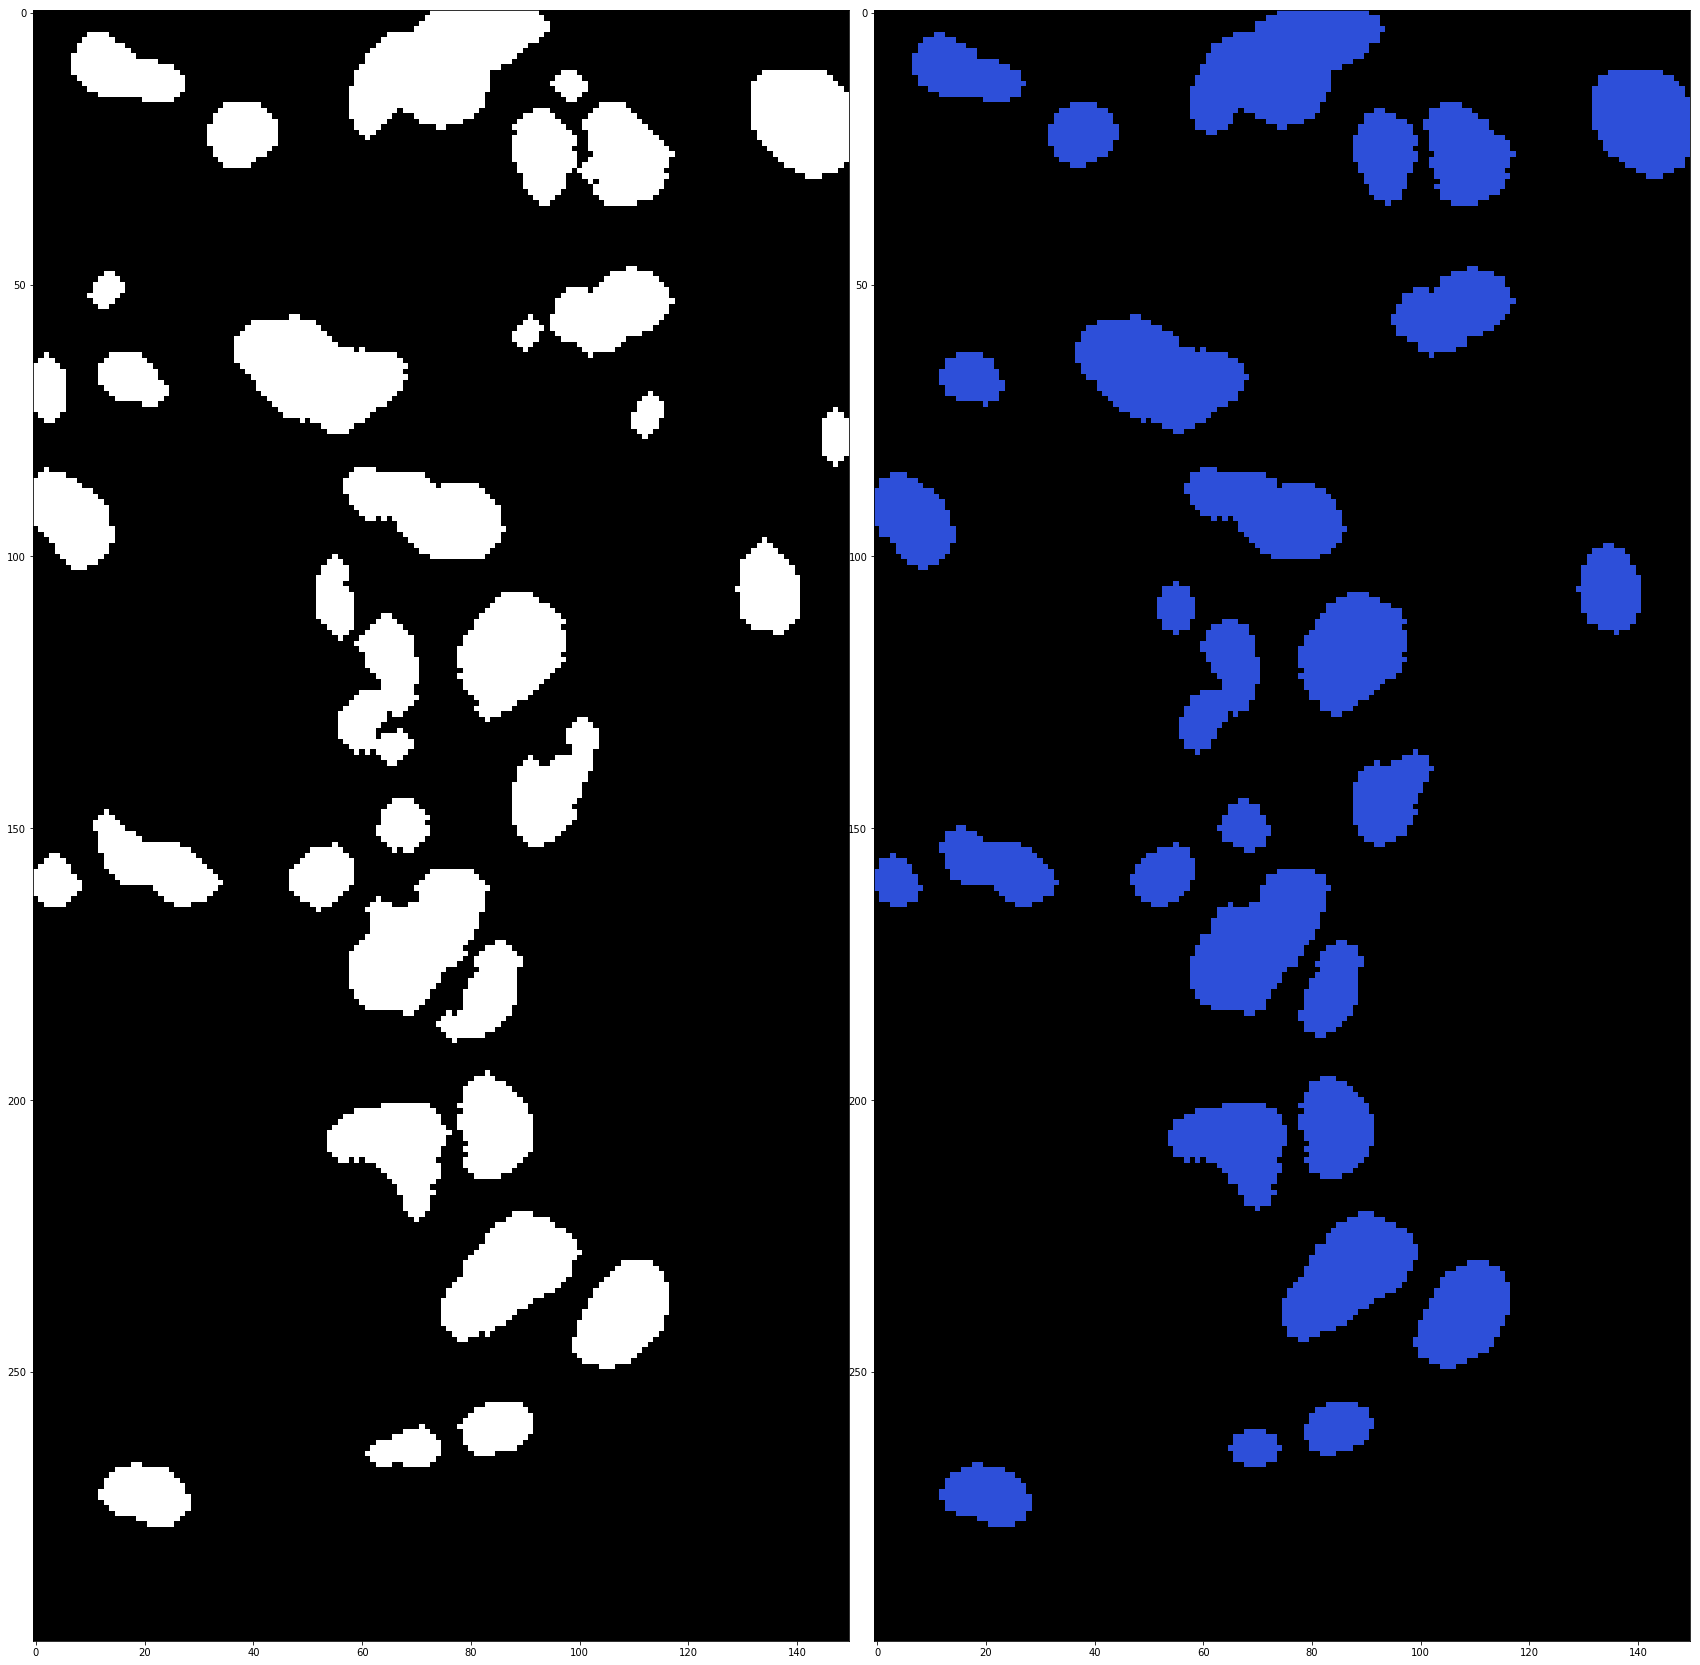

In [23]:
struct3 = create_disc(3)
print(struct3)

crop_erosion_opened_disc = scipy.ndimage.morphology.binary_opening(crop_erosion, struct3, iterations=1).astype(np.uint8) * 255

show_all(1,2,crop_erosion_opened,crop_erosion_opened_disc, scale=30, cmap='gray,rand')

0.996078431373


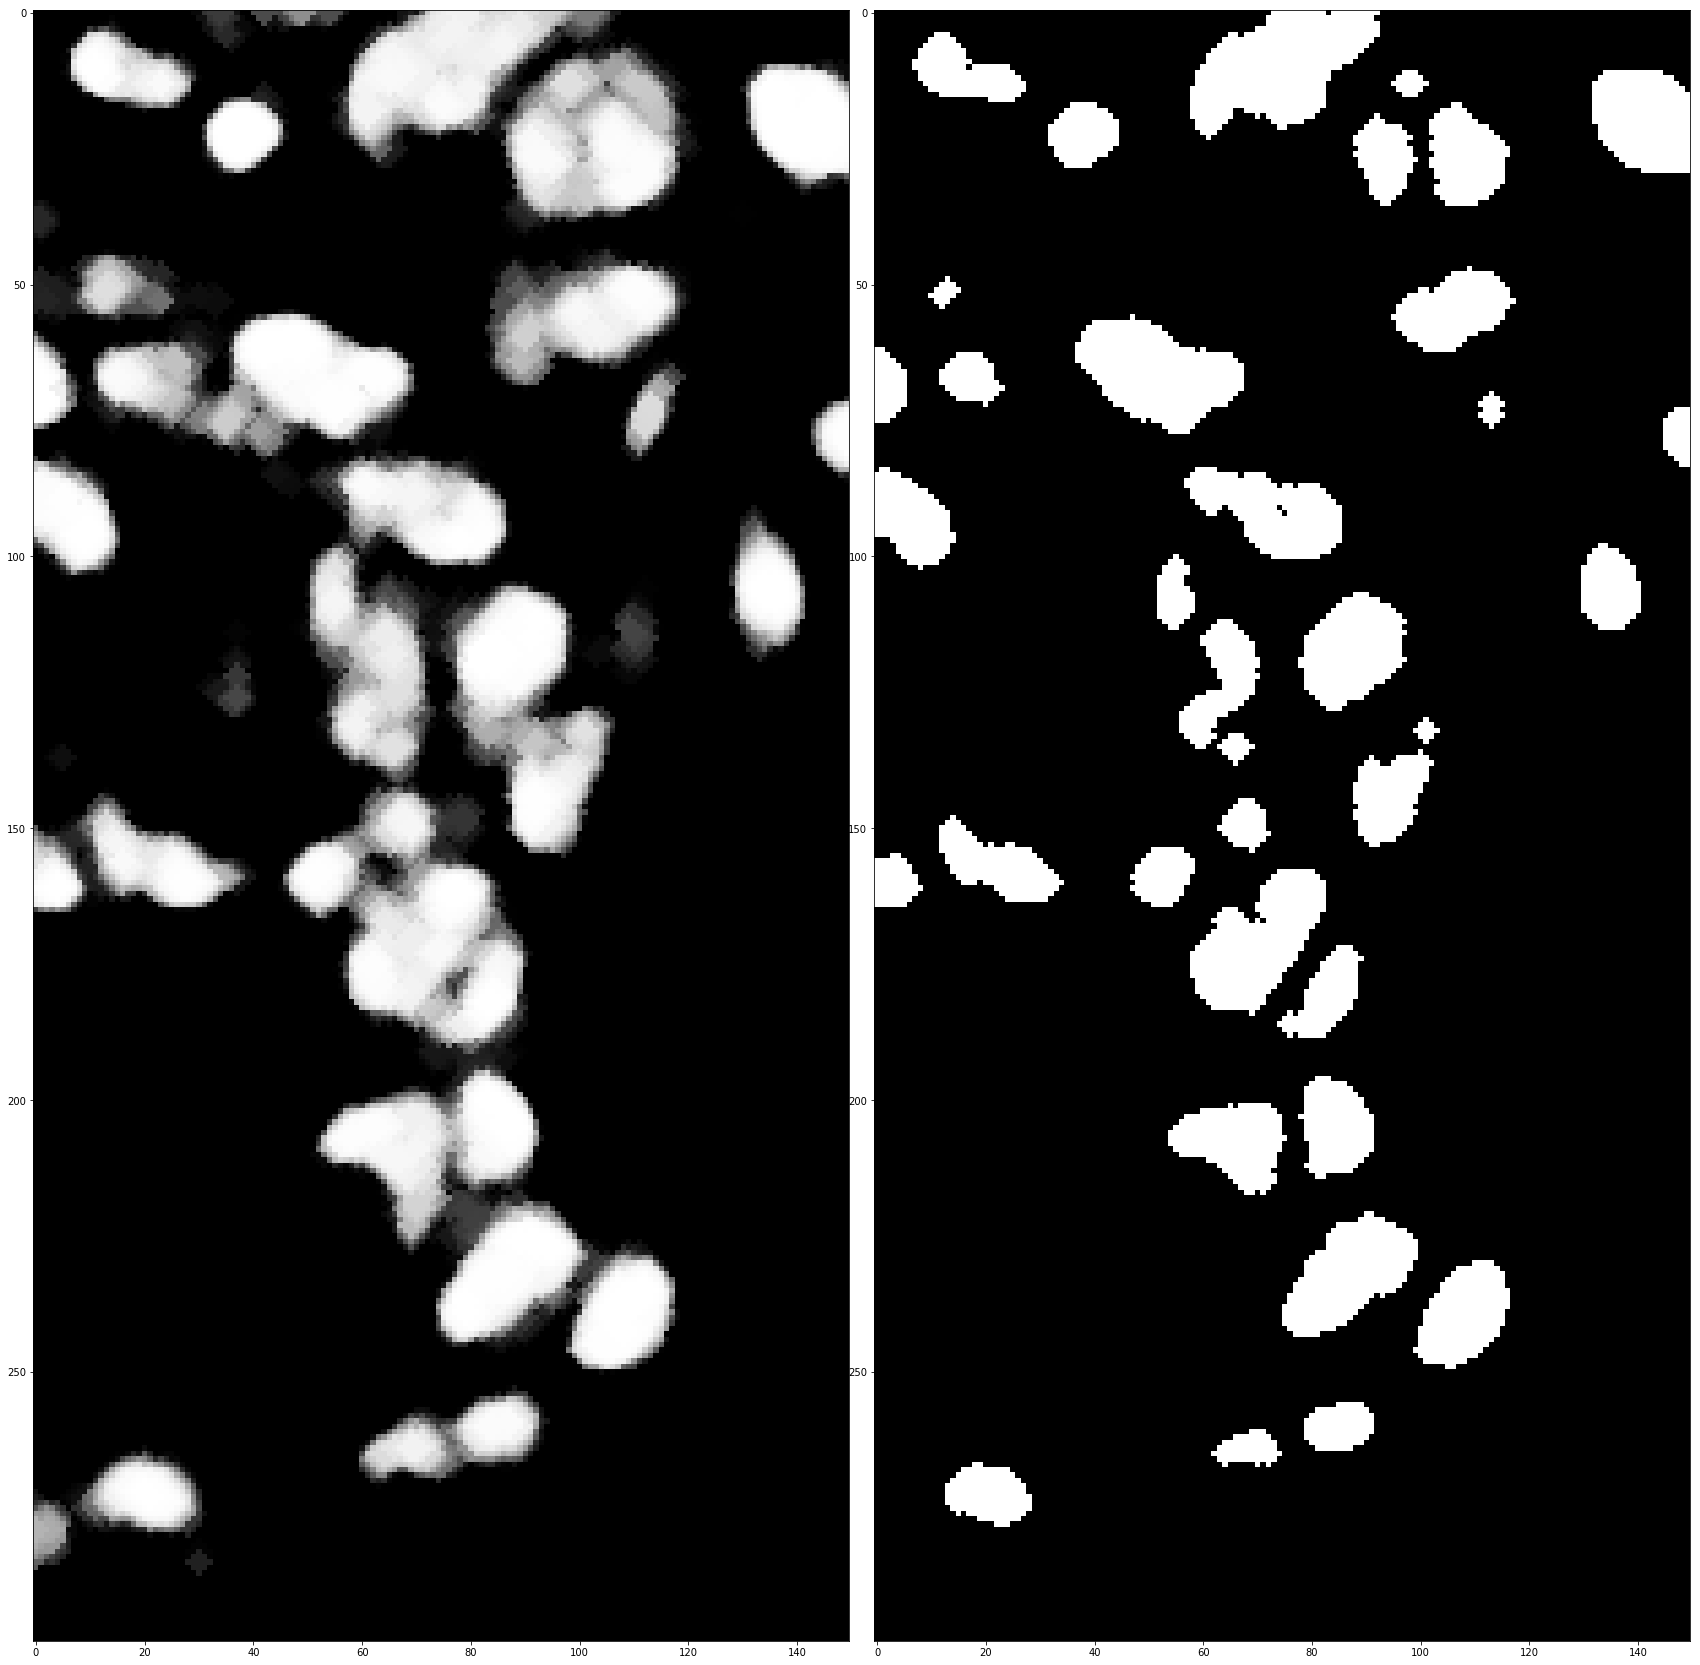

In [24]:
crop_opening = cp_segm_3[6][250:550,100:250]
crop_grayn_opened = scipy.ndimage.morphology.grey_opening(crop_opening, structure=create_disc(2))
print(crop_grayn_opened.max())
show_all(1,2,crop_grayn_opened,crop_grayn_opened>0.85, scale=30)